# A quick look into the mass-balance calibration procedure

The default mass-balance model of OGGM is a very standard [temperature index melt model](https://www.sciencedirect.com/science/article/pii/S0022169403002579). What's ... unusual about it, is the calibration procedure. We have explained it in quite some length in the [documentation](https://docs.oggm.org/en/stable/mass-balance.html), in [our paper](https://www.geosci-model-dev.net/12/909/2019/), in the [original publication](https://www.the-cryosphere.net/6/1295/2012/tc-6-1295-2012.html) that introduced it for the first time, and we have created [a website](https://cluster.klima.uni-bremen.de/~github/crossval/) to monitor its performance. The method is not perfect (by far), but it is quite powerful: I've often said that it is the best idea that Ben ever had, and he has a lot of good ideas.

However, experience shows that most people (including us sometimes ;) don't understnd how it works. Let's add a new tutorial to the list, and jump on the opportunity to play around with the calibration procedure (don't do this at home!).

## Set-up

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, climate

In [2]:
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-ref-mb', reset=True)
cfg.PARAMS['border'] = 10

2021-02-03 13:57:10: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:57:10: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:57:10: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:57:11: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


We start from two well known glaciers in the Austrian Alps, Kesselwandferner and Hintereisferner:

In [4]:
gdirs = workflow.init_glacier_directories(['RGI60-11.00787', 'RGI60-11.00897'], from_prepro_level=3)

2021-02-03 13:58:05: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2021-02-03 13:58:05: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers


The two glaciers are neighbors but have very different geometries:

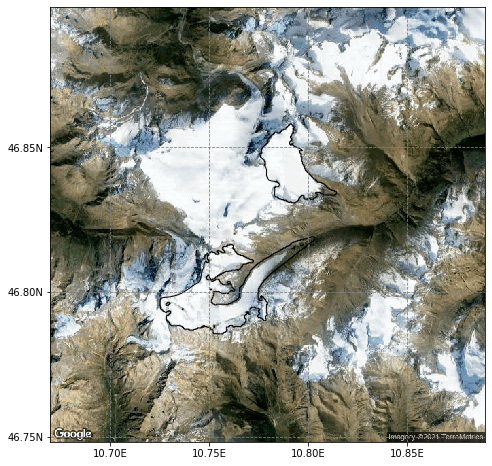

In [5]:
f, ax = plt.subplots(figsize=(8, 8))
graphics.plot_googlemap(gdirs, ax=ax)

## Calibration on glaciers with data

Like most models, they are always "perfect" where observations are available (both glaciers are reference glaciers in the WGMS database):

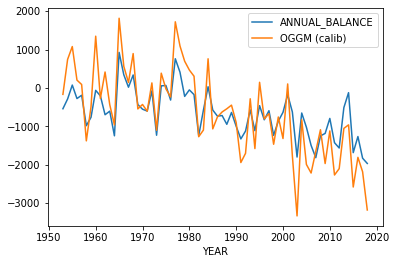

In [6]:
# Get HEF
gdir = gdirs[1]
# Get the reference mass-balance from the WGMS
ref_df = gdir.get_ref_mb_data()
# Get the calibrated mass-balance model
mbmod = massbalance.PastMassBalance(gdir)
# Compute the specific MB for this glacier
fls = gdir.read_pickle('inversion_flowlines')
ref_df['OGGM (calib)'] = mbmod.get_specific_mb(fls=fls, year=ref_df.index.values)
ref_df[['ANNUAL_BALANCE', 'OGGM (calib)']].plot();

Perfect? **Not really:** the model is calibrated so that the bias over the calibration period is zero, but other uncertainties remain: the variability in our timeseries is too high (this has something to do with precipitation amounts) and we have a stronger trend in the model than observations (this is due to the changing glacier geometry, that our model doesn't know about here: so this is more a "feature" than a bug). 

What's important for OGGM here is the bias, which is zero:

In [7]:
ref_df[['ANNUAL_BALANCE', 'OGGM (calib)']].mean()

ANNUAL_BALANCE   -647.742424
OGGM (calib)     -647.742437
dtype: float64

The calibration procedure did following: it found a year $t^*$ in the past which is selected so that the glacier, with its present day geometry, would be in equilibrium with a 31-yr climate centered on $t^*$ (see the [documentation](https://docs.oggm.org/en/stable/mass-balance.html) for more info). The year $t^*$ and the associated temperature sensitivity $\mu^*$ (units: mm K$^{-1}$ yr$^{-1}$) for this glacier are:

In [8]:
gdir.read_json('local_mustar')['t_star'], gdir.read_json('local_mustar')['mu_star_glacierwide']

(1974, 221.28378354824062)

What about Kesselwandferner?

In [9]:
gdir = gdirs[0]
gdir.read_json('local_mustar')['t_star'], gdir.read_json('local_mustar')['mu_star_glacierwide']

(1987, 343.0814484116781)

These are very different values! Not surprising: the two glaciers are in the same climate (from the forcing data) but are very different in size, orientation and geometry. The resulting mass-balance values are also different:

In [10]:
ref_df = gdir.get_ref_mb_data()
mbmod = massbalance.PastMassBalance(gdir)
ref_df['OGGM (calib)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), year=ref_df.index.values)
ref_df[['ANNUAL_BALANCE', 'OGGM (calib)']].mean()

ANNUAL_BALANCE   -165.393939
OGGM (calib)     -165.393968
dtype: float64

Kesselwandferner has a mass-balance less negative than its neighbor, probably because it is smaller in size and spans less altitude.

## Calibration on glaciers without data 

Let's trick OGGM a little. Let's make it appear that no data is available at Kesselwandferner for calibration:

In [11]:
# Set an empty reference mass-balance
gdir.set_ref_mb_data(ref_df.iloc[[]])

And re-run the mass-balance calibration:

In [15]:
cfg.PARAMS['run_mb_calibration'] = True
climate.compute_ref_t_stars(gdirs)
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2021-02-03 13:58:52: oggm.workflow: Execute entity task t_star_from_refmb on 1 glaciers
2021-02-03 13:58:53: oggm.workflow: Execute entity task local_t_star on 2 glaciers
2021-02-03 13:58:53: oggm.workflow: Execute entity task mu_star_calibration on 2 glaciers
100% of  46.9 MiB |######################| Elapsed Time: 0:00:02 Time:  0:00:02


Now, what's the new $\mu^*$ of Kesselwandferner?

In [16]:
gdir.read_json('local_mustar')['t_star'], gdir.read_json('local_mustar')['mu_star_glacierwide']

(1974, 425.1563837434307)

In the absence of other glaciers to interpolate from (usually the 10 closest), OGGM simply assigned the value of $t^*$ from Hintereisferner to Kesselwandferner (1963). From this, $\mu^*$ could be estimated. This "blind" mass-balance model is of course not as good as if we calibrated it using observations:

In [17]:
mbmod = massbalance.PastMassBalance(gdir)
ref_df['OGGM (blind)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), year=ref_df.index.values)
ref_df[['ANNUAL_BALANCE', 'OGGM (calib)', 'OGGM (blind)']].mean()

ANNUAL_BALANCE    -165.393939
OGGM (calib)      -165.393968
OGGM (blind)     -1007.559374
dtype: float64

Quite a negative bias! This is as good as OGGM can be in the absence of observations and without any other reference glacier in vicinity (OGGM needs at least one). 

What else could we do to calibrate  $\mu^*$  for this glacier? We tried for example to simply interpolate $\mu^*$, and found that on average, this leads to worse results. Here for example: 

In [18]:
mbmod = massbalance.PastMassBalance(gdir, mu_star=221.275)  # Apply mu* from Hintereisferner
ref_df['OGGM (μ∗ from HEF)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), year=ref_df.index.values)
ref_df[['ANNUAL_BALANCE', 'OGGM (calib)', 'OGGM (blind)', 'OGGM (μ∗ from HEF)']].mean()

ANNUAL_BALANCE        -165.393939
OGGM (calib)          -165.393968
OGGM (blind)         -1007.559374
OGGM (μ∗ from HEF)     958.740862
dtype: float64

Interpolating $\mu^*$ instead of $t^*$ is quite quite worse! And we found out that this is generally the case globally:

![img](https://docs.oggm.org/en/latest/_images/mb_crossval_panel.png)
*Benefit of spatially interpolating $t^*$ instead of $\mu^*$ as shown by leave-one-glacier-out cross-validation (N = 255). Left: error distribution of the computed mass-balance if determined by the interpolated $t^*$. Right: error distribution of the mass-balance if determined by interpolation of $\mu^*$. From [Maussion et al., 2019](https://www.geosci-model-dev.net/12/909/2019)*

If you come up with a great idea to make the calibration procedure better, please reach out! We have some ideas, but haven't come up to try it yet. There are so many things we want to try out with OGGM!

## Bonus: additional MB data for OGGM

This is a rare, but possible use case: you might have mass-balance data that is not yet available in the WGMS database, or reanalyzed data that you would like to use in place of the default WGMS. Doing this is quite simple: let's assume we have some secret data for a third glacier, here the Oberer Grindelwald Glacier in the Swiss Alps (this is an example of course):

In [21]:
gdirs = workflow.init_glacier_directories(['RGI60-11.00787', 'RGI60-11.00897', 'RGI60-11.01270'], from_prepro_level=3, reset=True, force=True)
# Let's make sure that OGG is not a reference glacier: this line would throw an error:
# gdirs[2].get_ref_mb_data()

2021-02-03 13:59:59: oggm.workflow: init_glacier_directories from prepro level 3 on 3 glaciers.
2021-02-03 13:59:59: oggm.workflow: Execute entity task gdir_from_prepro on 3 glaciers


**First**, let's start by adding some data to this glacier. We are just creating some fake data and giving it to the glacier directory object.

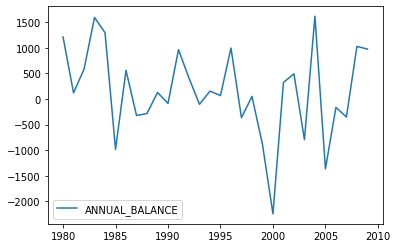

In [22]:
# This dataframe just needs some index and an 'ANN'
df = pd.DataFrame(index=range(1980, 2010))
# Get random but repeatable results
np.random.seed(0)
df['ANNUAL_BALANCE'] = np.random.randn(len(df.index)) * 800 - 200
df.plot();

# Give it to the object
gdir = gdirs[2]  # get OGG
gdir.set_ref_mb_data(df)

**Second**, we have to tell OGGM that this glacier is a reference glacier. We do this by adding it's ID to the list:

In [23]:
# Make sure the default list is generated
utils.get_ref_mb_glaciers_candidates(rgi_version='6');
# Append our glacier
cfg.DATA['RGI60_ref_ids'].append(gdir.rgi_id)
# Make sure all three glaciers are now reference glaciers
assert len(utils.get_ref_mb_glaciers(gdirs)) == 3

**Third**, re-run the calibration!

In [25]:
cfg.PARAMS['run_mb_calibration'] = True
climate.compute_ref_t_stars(gdirs)
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2021-02-03 14:00:12: oggm.workflow: Execute entity task t_star_from_refmb on 3 glaciers
2021-02-03 14:00:13: oggm.workflow: Execute entity task local_t_star on 3 glaciers
2021-02-03 14:00:13: oggm.workflow: Execute entity task mu_star_calibration on 3 glaciers


**Note:** what just happened here? We asked OGGM to recalibrate its mass-balance model. In essence, it is as simple as computing a list of so-called "reference $t^*$" from which the model can interpolate from. This list is then written as CSV file in the working directory:

In [26]:
df_tstar = pd.read_csv(os.path.join(cfg.PATHS['working_dir'], 'ref_tstars.csv'), index_col=0)
df_tstar

,lon,lat,n_mb_years,tstar,bias
RGI60-11.00787,10.79070,46.8424,66,1987,-45.921389
RGI60-11.00897,10.75840,46.8003,66,1974,4.685993
RGI60-11.01270,8.11933,46.6143,30,1998,13.840692


This list has to be generated once, and **has to be copied in each working directory you use if you want OGGM to take it into account**. In the absence of this file in the working directory, OGGM will use its default pre-calibrated file, located in the online [sample data repository](https://github.com/OGGM/oggm-sample-data/blob/master/wgms/oggm_ref_tstars_rgi6_cru4.csv).

After copying the file in a fresh working directory, the task `compute_ref_t_stars` should not be called. Only `local_t_star` and `mu_star_calibration` matter.

Let's see how well our new glacier's mass-balance can be reproduced:

In [27]:
ref_df = gdir.get_ref_mb_data()
mbmod = massbalance.PastMassBalance(gdir)
ref_df['OGGM (fake calib)'] = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'), 
                                                    year=ref_df.index.values)
ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].mean()

ANNUAL_BALANCE       154.285158
OGGM (fake calib)    154.285126
dtype: float64

A bias of zero! Works perfectly, right? ;-) 

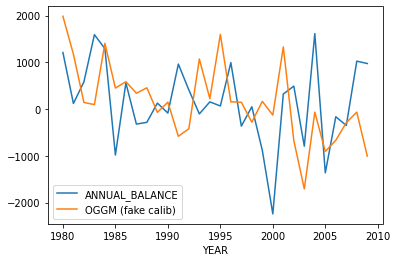

In [28]:
ref_df[['ANNUAL_BALANCE', 'OGGM (fake calib)']].plot();

## Take home points

- We illustrated with a simplified example how to do a simple cross-validation of the mass-balance calibration of OGGM. In reality, the $t^*$ are interpolated, not assigned like this. The results of the full cross-validation are therefore different for Kesselwandferner.
- It is possible to play around with OGGM mass-balance data for sensitivity experiments.
- It is also possible to add custom mass-balance data to OGGM glaciers and re-calibrate the model based on this data
- The mass-balance model of OGGM can lead to substantial biases at the local scale. We show that *on average* the bias is low, but individual glaciers can have substantial biases.
- Future improvements will have to deal with this bias, e.g. by making use of the increasingly available geodetic mass-balance measurements.

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)